In [179]:
import os
import sys
import tarfile
import pandas as pd
import gzip
from io import BytesIO
from io import StringIO
import numpy as np
import csv
import gzip
import re
# Plotting and miscellaneous imports
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [131]:
%matplotlib inline

In [3]:
import palantir

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
from datasets import geoREAD

In [5]:
geo = geoREAD('GSE118828_RAW.tar','./datasets/')

In [6]:
geo.gsm_files

['GSM3348303_553_Perit_S1.counts.umiCounts.aboveBackground.table.csv.gz',
 'GSM3348304_565_Cystadenoma_S1.counts.umiCounts.aboveBackground.table.csv.gz',
 'GSM3348305_589_Omentum_S1.counts.umiCounts.aboveBackground.table.csv.gz',
 'GSM3348306_618_Ovary_S1.counts.umiCounts.table.csv.gz',
 'GSM3348307_TB10040568_NORMAL_S1.counts.umiCounts.table.csv.gz',
 'GSM3348308_TB10040568_TUMOR_S1.counts.umiCounts.table.csv.gz',
 'GSM3348309_TB10040580_S1.counts.umiCounts.table.csv.gz',
 'GSM3348310_TB10040580met_S1_1_.counts.umiCounts.table.csv.gz',
 'GSM3348311_TB10040589_4_S1.counts.umiCounts.table.csv.gz',
 'GSM3348312_TB10040589met_S1.counts.umiCounts.table.csv.gz',
 'GSM3348313_TB10040600_CD31_S1.counts.umiCounts.table.csv.gz',
 'GSM3348314_TB10040600_NP-1_S1.counts.umiCounts.table.csv.gz',
 'GSM3348315_TB10040600_NP-2_S1.counts.umiCounts.table.csv.gz',
 'GSM3348316_TB10040600_Tumor_S1.counts.umiCounts.table.csv.gz',
 'GSM3348317_TB10040626_OMENTUM_S1.counts.umiCounts.table.csv.gz',
 'GSM33483

In [7]:
data = pd.DataFrame()
for i in [4,5]:
    temp = geo.readGSM(geo.gsm_files[i])
    data = pd.concat([data,temp],axis=0)

In [8]:
counts = data.set_index('CellId')

In [ ]:
barcode2celltype = pd.read_table('../data/barcode2celltype.tsv')

### Data clean up

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


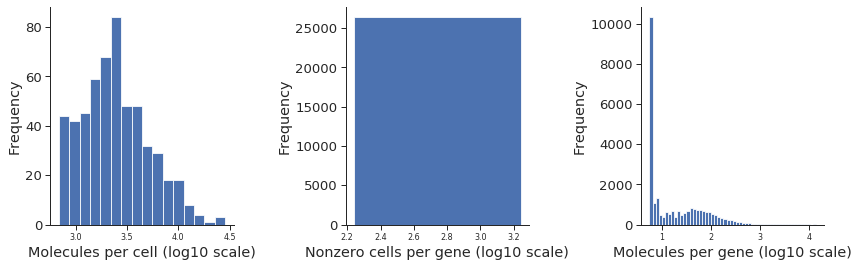

In [9]:
fig, ax = palantir.plot.\
plot_molecules_per_cell_and_gene(np.add(counts.values,0.01))

### Normalization

In [10]:
norm_df = palantir.preprocess.normalize_counts(counts)

In [11]:
norm_df = palantir.preprocess.log_transform(norm_df)

#### Principal component analysis

In [12]:
pca_projections, _ = palantir.utils.run_pca(norm_df)

#### Diffusion maps

In [13]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...


In [14]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

In [15]:
tsne = palantir.utils.run_tsne(ms_data)

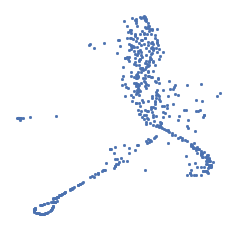

In [16]:
fig, ax = palantir.plot.plot_tsne(tsne)

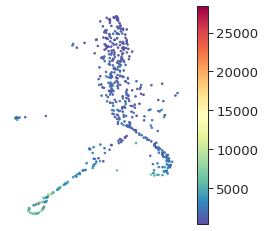

In [17]:
fig, ax = palantir.plot.plot_tsne_by_cell_sizes(counts, tsne)

In [18]:
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

### Cell type overlay

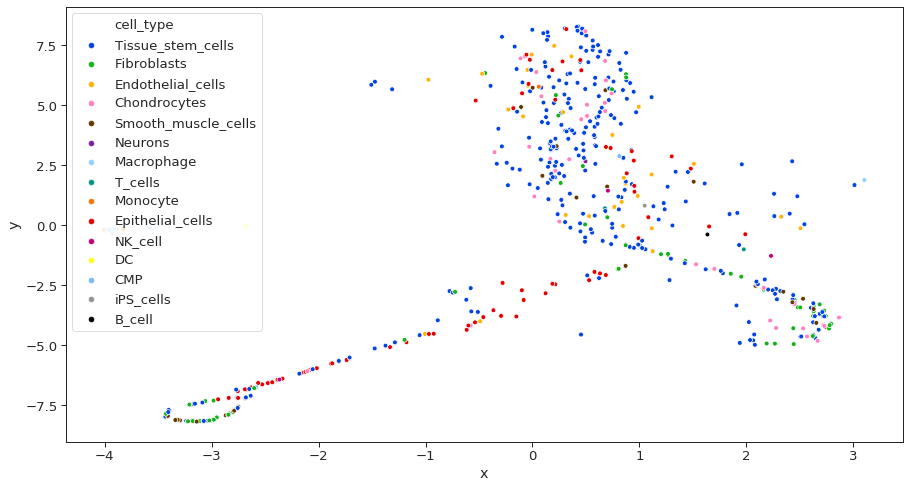

In [203]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(x="x", y="y",hue='cell_type',\
                    data=tsne,ax=ax)

In [207]:
# Adopted from Shih et al., PLoS One (2018)
epithelial = ['EPCAM', 'KRT8', 'KRT18', 'KRT19']
lymphocyte = ['PTPRC', 'CD3E', 'CD19', 'MS4A1']
endothelial = ['PECAM1', 'CD34']
fibroblast = ['ACTA2', 'DCN', 'ACTB']
stromal = ['THY1', 'ENG', 'VIM', 'CD44']
### Ovarian cancer marker expression
ov_epithelial = ['FXYD3', 'CD24', 'ELF3',
                        'MUC1','KRT19']

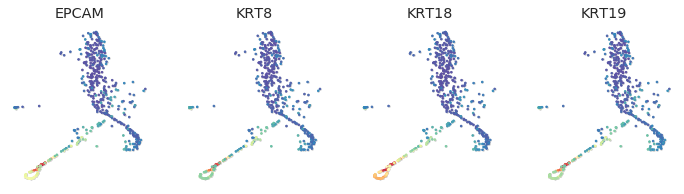

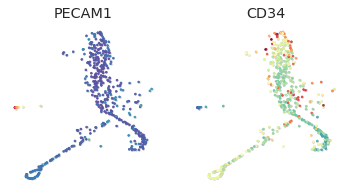

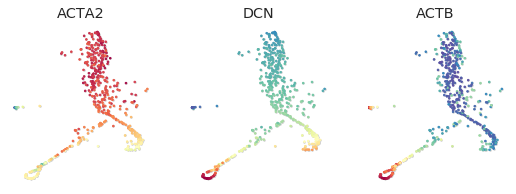

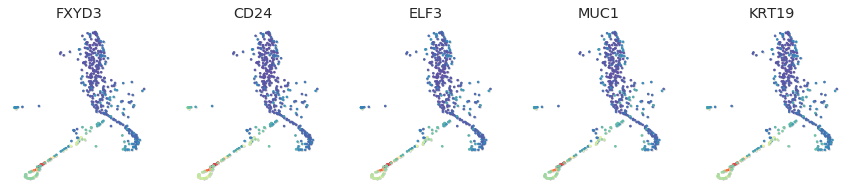

In [209]:
palantir.plot.plot_gene_expression(imp_df, tsne,epithelial)
#palantir.plot.plot_gene_expression(imp_df, tsne,lymphocyte)
palantir.plot.plot_gene_expression(imp_df, tsne,endothelial)
palantir.plot.plot_gene_expression(imp_df, tsne,fibroblast)
#palantir.plot.plot_gene_expression(imp_df, tsne,stromal)
### Ovarian cancer marker expression
palantir.plot.plot_gene_expression(imp_df, tsne,ov_epithelial)

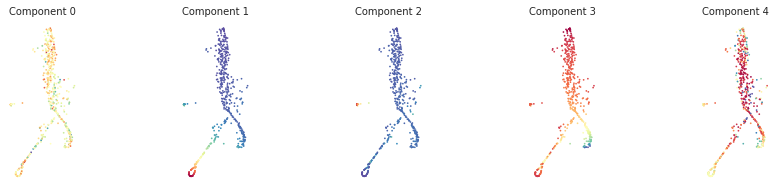

In [210]:
palantir.plot.plot_diffusion_components(tsne, dm_res)

### Running Palantir

In [46]:
start_cell = 'cgagcagccagattcgca'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0007574995358784994 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.07148999770482381 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


#### Starting cell

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f145dee7790>)

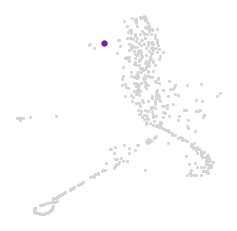

In [113]:
palantir.plot.highlight_cells_on_tsne(tsne, start_cell)

#### Visualization of terminal states

In [111]:
term_states = pr_res.branch_probs.columns.values

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f145de73390>)

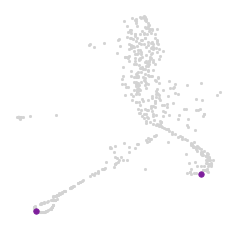

In [118]:
palantir.plot.highlight_cells_on_tsne(tsne, term_states)

In [123]:
mapping = pd.Series(index=['Healthy','Tumor'])
mapping['Healthy'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
mapping['Tumor'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmax()
mapping = pd.Series(mapping.index,index=mapping)

In [126]:
pr_res.branch_probs.columns = mapping[pr_res.branch_probs.columns]
pr_res.branch_probs = pr_res.branch_probs\
.loc[:, ['Healthy', 'Tumor']]

### Visualizing Palantir results

In [ ]:
#Important note: The differentiation potential does not line up with the pseudotime

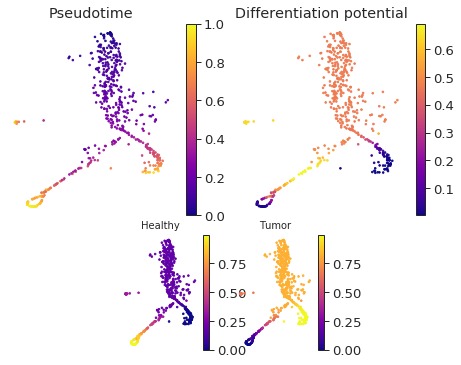

In [128]:
palantir.plot.plot_palantir_results(pr_res, tsne)

In [223]:
#CCNE1, CDKN2A, KRAS, PTEN and RB1
genes = ['CD34', 'VIM','IRF8','KRAS','CCNE1','CDKN2A','PTEN','RB1']
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

Healthy
Time for processing Healthy: 0.006788321336110433 minutes
Tumor
Time for processing Tumor: 0.005178670088450114 minutes


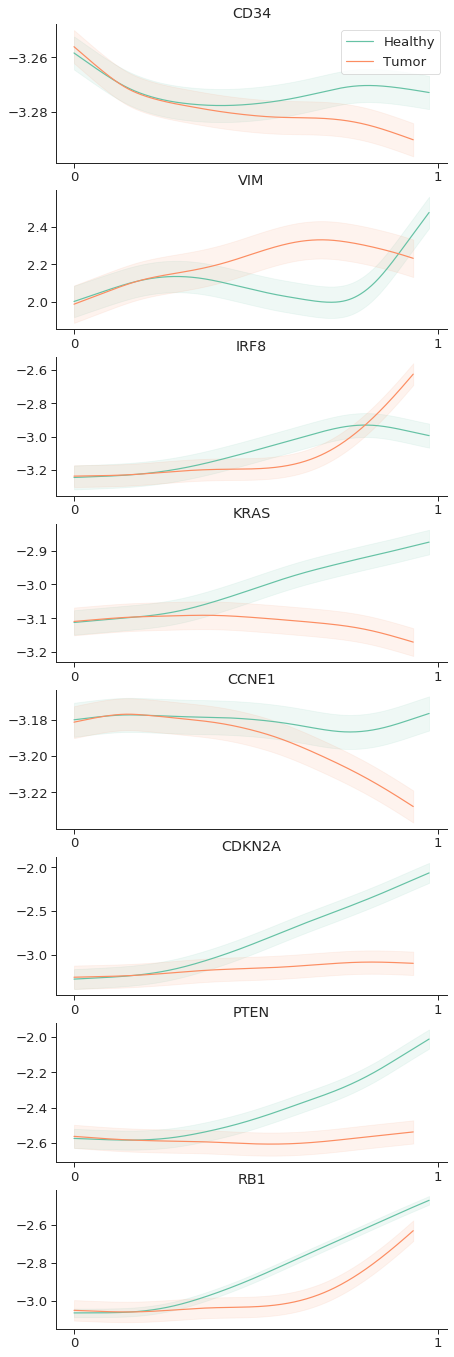

In [224]:
palantir.plot.plot_gene_trends(gene_trends)

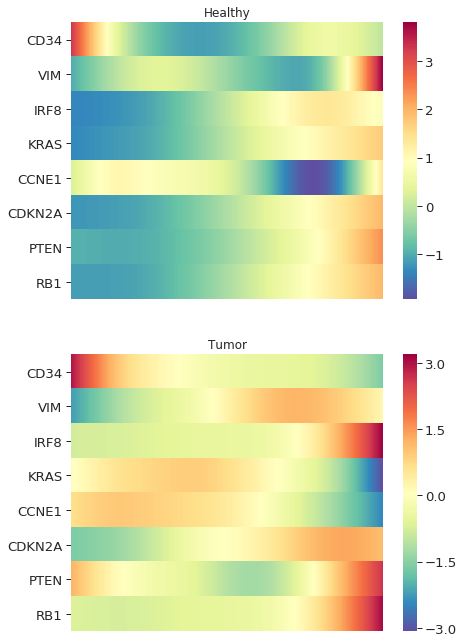

In [225]:
palantir.plot.plot_gene_trend_heatmaps(gene_trends)

### Clustering

In [138]:
clusters = palantir.utils.determine_cell_clusters(pca_projections)

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.24295425415039062 seconds
Jaccard graph constructed in 0.39116907119750977 seconds
Wrote graph to binary file in 0.10317492485046387 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.325756
After 2 runs, maximum modularity is Q = 0.327952
Louvain completed 22 runs in 0.9808621406555176 seconds
PhenoGraph complete in 1.7350220680236816 seconds


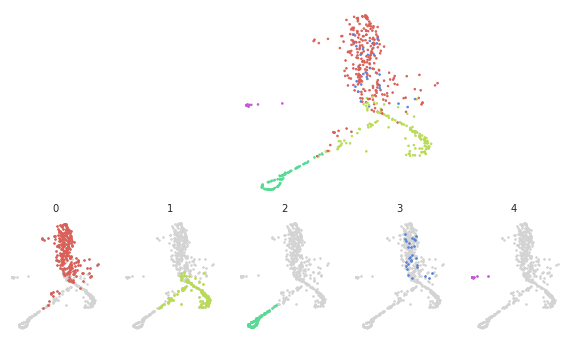

In [139]:
palantir.plot.plot_cell_clusters(tsne, clusters )

Clustering of the gene expression trends in a similar manner

In [140]:
gene_trends = palantir.presults.compute_gene_trends(pr_res, 
                    imp_df.iloc[:, 0:1000], ['Healthy'])

Healthy
Time for processing Healthy: 0.5374172568321228 minutes


In [141]:
# Cluster
trends = gene_trends['Healthy']['trends']
gene_clusters = palantir.presults.cluster_gene_trends(trends)

Finding 150 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3531641960144043 seconds
Jaccard graph constructed in 4.31834077835083 seconds
Wrote graph to binary file in 0.7085957527160645 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.611905
Louvain completed 21 runs in 1.2911884784698486 seconds
PhenoGraph complete in 6.713732957839966 seconds


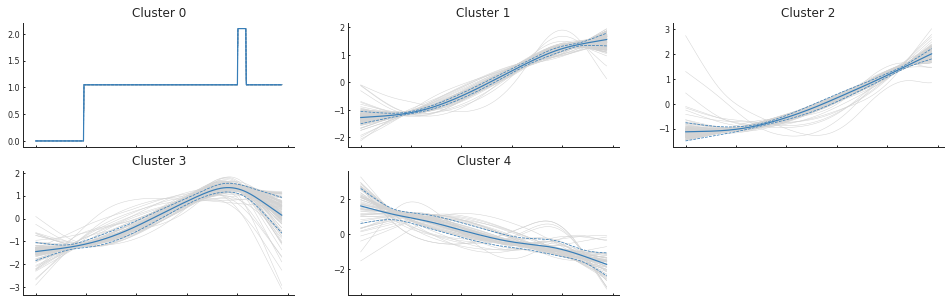

In [142]:
palantir.plot.plot_gene_trend_clusters(trends, gene_clusters)